- https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html
- http://mostafadehghani.com/2019/05/05/universal-transformers/
- http://jalammar.github.io/illustrated-transformer/
- https://vimeo.com/232544904

In [1]:
# !conda install -c pytorch -c fastai fastai --yes

We are going to study attention in deep learning. We are going to follow [Lilian's](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) amazing blog post on `Attention`.

> Attention has been a fairly popular concept and a useful tool in the deep learning community in recent years. In this post, we are gonna look into how attention was invented, and various attention mechanisms and models, such as transformer and SNAIL.

In a nutshell, attention in the deep learning can be broadly interpreted as a vector of importance weights: in order to predict or infer one element, such as a pixel in an image or a word in a sentence, we estimate using the attention vector how strongly it is correlated with (or “attends to” as you may have read in many papers) other elements and take the sum of their values weighted by the attention vector as the approximation of the target.

In [1]:
!pwd

/Users/vks/Desktop/deep-unsupervised-learning/fai-part2/research-lib/nbs/projects


In [2]:
import sys
sys.path.insert(0, '../')

In [3]:
from lib.nb_07 import *

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Seq2Seq: Translating French questions to English Questions

### Data

#### Get Data

Getting the dataset.

In [ ]:
path = datasets.Config().data_path()

In [ ]:
#! wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {path}

In [ ]:
#! tar xf {path}/giga-fren.tgz -C {path} 

In [ ]:
(path/"giga-fren").ls()

In [ ]:
# with open(path/'giga-fren/giga-fren.release2.fixed.fr') as f:
#     fr = f.read().split('\n')

In [ ]:
# with open(path/'giga-fren/giga-fren.release2.fixed.en') as f:
#     en = f.read().split('\n')

In [ ]:
# re_eq = re.compile('^(Wh[^?.!]+\?)')
# re_fq = re.compile('^([^?.!]+\?)')
# en_fname = path/'giga-fren/giga-fren.release2.fixed.en'
# fr_fname = path/'giga-fren/giga-fren.release2.fixed.fr'

In [ ]:
# lines = ((re_eq.search(eq), re_fq.search(fq)) 
#         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))
# qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [ ]:
# qs = [(q1,q2) for q1,q2 in qs]
# df = pd.DataFrame({'fr': [q[1] for q in qs], 'en': [q[0] for q in qs]}, columns = ['en', 'fr'])
# df.to_csv(path/'questions_easy.csv', index=False)

In [ ]:
path = datasets.Config().data_path()/'giga-fren'
path.ls()

#### Databunch

In [5]:
path = datasets.Config().data_path()

In [6]:
df = pd.read_csv(path/'questions_easy.csv')
df.head(n=10)

,en,fr
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...
5,What is the major aboriginal group on Vancouve...,Quel est le groupe autochtone principal sur l’...
6,What are the advantages and disadvantages of u...,Quels sont les avantages et les désavantages d...
7,What types of land cover are associated with t...,À quel type de couverture des terres associez-...
8,What is the population of Canada?,Quelle est la population du Canada ?
9,Which province is the most populated?,Quelle est la province la plus peuplée ?


In [8]:
df.shape

(52331, 2)

> there are 52331 unique question answer pairs.

What we need to do:

- Get files: `ImageList`
- Split validation set
  - random%, folder name, csv, ...
- Label: 
  - folder name, file name/re, csv, ...
- Transform per image (optional)
- Transform to tensor
- DataLoader
- Transform per batch (optional)
- DataBunch
- Add test set (optional)

In [7]:
raw_data = df.to_numpy()

In [8]:
il = TextList(raw_data)

In [9]:
il

TextList (52331 items)
[array(['What is light ?', 'Qu’est-ce que la lumière?'], dtype=object), array(['Who are we?', 'Où sommes-nous?'], dtype=object), array(['Where did we come from?', "D'où venons-nous?"], dtype=object), array(['What would we do without it?', 'Que ferions-nous sans elle ?'], dtype=object), array(['What is the absolute location (latitude and longitude) of Badger, Newfoundland and Labrador?',
       'Quelle sont les coordonnées (latitude et longitude) de Badger, à Terre-Neuve-etLabrador?'], dtype=object), array(['What is the major aboriginal group on Vancouver Island?',
       'Quel est le groupe autochtone principal sur l’île de Vancouver?'], dtype=object), array(['What are the advantages and disadvantages of using an online atlas versus a paper atlas?',
       'Quels sont les avantages et les désavantages d’utiliser un atlas en ligne comparativement à un atlas en copie papier?'],
      dtype=object), array(['What types of land cover are associated with the colours be

In [10]:
il[0]

array(['What is light ?', 'Qu’est-ce que la lumière?'], dtype=object)

In [17]:
random.seed(42)
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid=0.05))

In [18]:
sd

SplitData
Train: TextList (49732 items)
[array(['What is light ?', 'Qu’est-ce que la lumière?'], dtype=object), array(['Where did we come from?', "D'où venons-nous?"], dtype=object), array(['What would we do without it?', 'Que ferions-nous sans elle ?'], dtype=object), array(['What is the absolute location (latitude and longitude) of Badger, Newfoundland and Labrador?',
       'Quelle sont les coordonnées (latitude et longitude) de Badger, à Terre-Neuve-etLabrador?'], dtype=object), array(['What is the major aboriginal group on Vancouver Island?',
       'Quel est le groupe autochtone principal sur l’île de Vancouver?'], dtype=object), array(['What are the advantages and disadvantages of using an online atlas versus a paper atlas?',
       'Quels sont les avantages et les désavantages d’utiliser un atlas en ligne comparativement à un atlas en copie papier?'],
      dtype=object), array(['What types of land cover are associated with the colours below?',
       'À quel type de couverture

```python
def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)
```

```python
class LabeledData():
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x,self.y = self.process(x, proc_x),self.process(y, proc_y)
        self.proc_x,self.proc_y = proc_x,proc_y

    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)

    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)

    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx,torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)
```

In [19]:
def label_txt2txt_sd(sd, proc_x=None, proc_y=None):
    
    #train
    x_train = TextList([x for x, y in sd.train])
    y_train = TextList([y for x, y in sd.train])
    ll_train = LabeledData(x_train, y_train, proc_x=proc_x, proc_y=proc_y)
    
    #train
    x_valid = TextList([x for x, y in sd.valid])
    y_valid = TextList([y for x, y in sd.valid])
    ll_valid = LabeledData(x_valid, y_valid, proc_x=proc_x, proc_y=proc_y)
    
    return SplitData(ll_train,ll_valid)

In [20]:
proc_x = [TokenizeProcessor(lang="en"), NumericalizeProcessor()]
proc_y = [TokenizeProcessor(lang="fr"), NumericalizeProcessor()]

In [21]:
proc_x[-1], proc_y[-1]

(<lib.nb_05.NumericalizeProcessor at 0x1a26e4bda0>,
 <lib.nb_05.NumericalizeProcessor at 0x1a26e64e10>)

In [22]:
ll = label_txt2txt_sd(sd, proc_x=proc_x, proc_y=proc_y)

In [23]:
(ll.train.proc_x[-1], ll.valid.proc_x[-1]), (ll.train.proc_y[-1], ll.valid.proc_y[-1])

((<lib.nb_05.NumericalizeProcessor at 0x1a26e4bda0>,
  <lib.nb_05.NumericalizeProcessor at 0x1a26e4bda0>),
 (<lib.nb_05.NumericalizeProcessor at 0x1a26e64e10>,
  <lib.nb_05.NumericalizeProcessor at 0x1a26e64e10>))

If we do not do this, we get different lengths of otoi and vocab whihc is weird, this should be fixed later.

In [24]:
ll.train.proc_x[-1].otoi = None
ll.train.proc_x[-1].otoi = collections.defaultdict(int,{v:k for k,v in enumerate(ll.train.proc_x[-1].vocab)})

ll.train.proc_y[-1].otoi = None
ll.train.proc_y[-1].otoi = collections.defaultdict(int,{v:k for k,v in enumerate(ll.train.proc_y[-1].vocab)})

In [25]:
len(ll.train.proc_x[-1].vocab), len(ll.train.proc_x[-1].otoi)

(11580, 11580)

In [26]:
len(ll.valid.proc_x[-1].vocab), len(ll.valid.proc_x[-1].otoi)

(11580, 11580)

In [27]:
len(ll.train.proc_y[-1].vocab), len(ll.train.proc_y[-1].otoi)

(15147, 15147)

In [28]:
len(ll.valid.proc_y[-1].vocab), len(ll.valid.proc_y[-1].otoi)

(15147, 15147)

In [29]:
(ll.train.proc_x[-1], ll.valid.proc_x[-1]), (ll.train.proc_y[-1], ll.valid.proc_y[-1])

((<lib.nb_05.NumericalizeProcessor at 0x1a26e4bda0>,
  <lib.nb_05.NumericalizeProcessor at 0x1a26e4bda0>),
 (<lib.nb_05.NumericalizeProcessor at 0x1a26e64e10>,
  <lib.nb_05.NumericalizeProcessor at 0x1a26e64e10>))

In [30]:
ll

SplitData
Train: LabeledData
x: TextList (49732 items)
[[2, 7, 10, 14, 1412, 8, 3], [2, 7, 40, 62, 49, 267, 48, 8, 3], [2, 7, 10, 43, 49, 20, 465, 42, 8, 3], [2, 7, 10, 14, 9, 3659, 1070, 50, 4756, 13, 6423, 47, 11, 7, 5713, 17, 7, 2310, 13, 7, 7401, 8, 3], [2, 7, 10, 14, 9, 331, 294, 263, 27, 7, 3324, 7, 2248, 8, 3], [2, 7, 10, 16, 9, 406, 13, 906, 11, 296, 52, 1337, 5714, 1413, 18, 1129, 5714, 8, 3], [2, 7, 10, 154, 11, 538, 955, 16, 407, 39, 9, 2935, 2050, 8, 3], [2, 7, 10, 14, 9, 323, 11, 7, 46, 8, 3], [2, 7, 37, 744, 63, 9, 687, 323, 3482, 8, 3], [2, 7, 37, 744, 14, 9, 838, 7402, 8, 3]...]
Path: .
y: TextList (49732 items)
[[2, 7, 45, 18, 44, 19, 12, 2061, 8, 3], [2, 29, 65, 9212, 11, 62, 8, 3], [2, 7, 19, 11317, 11, 62, 294, 67, 8, 3], [2, 7, 39, 20, 10, 4069, 61, 4593, 14, 7812, 54, 9, 7, 0, 17, 16, 7, 964, 11, 7, 7813, 11, 0, 8, 3], [2, 7, 34, 18, 13, 238, 1300, 667, 38, 27, 2697, 9, 7, 4314, 8, 3], [2, 7, 26, 20, 10, 115, 14, 10, 2601, 35, 177, 32, 6258, 22, 520, 2517, 16, 32,

In [31]:
en_vocab = ll.train.proc_x[-1].vocab
fr_vocab = ll.train.proc_y[-1].vocab

In [32]:
len(en_vocab), len(fr_vocab)

(11580, 15147)

In [33]:
ll.train

LabeledData
x: TextList (49732 items)
[[2, 7, 10, 14, 1412, 8, 3], [2, 7, 40, 62, 49, 267, 48, 8, 3], [2, 7, 10, 43, 49, 20, 465, 42, 8, 3], [2, 7, 10, 14, 9, 3659, 1070, 50, 4756, 13, 6423, 47, 11, 7, 5713, 17, 7, 2310, 13, 7, 7401, 8, 3], [2, 7, 10, 14, 9, 331, 294, 263, 27, 7, 3324, 7, 2248, 8, 3], [2, 7, 10, 16, 9, 406, 13, 906, 11, 296, 52, 1337, 5714, 1413, 18, 1129, 5714, 8, 3], [2, 7, 10, 154, 11, 538, 955, 16, 407, 39, 9, 2935, 2050, 8, 3], [2, 7, 10, 14, 9, 323, 11, 7, 46, 8, 3], [2, 7, 37, 744, 63, 9, 687, 323, 3482, 8, 3], [2, 7, 37, 744, 14, 9, 838, 7402, 8, 3]...]
Path: .
y: TextList (49732 items)
[[2, 7, 45, 18, 44, 19, 12, 2061, 8, 3], [2, 29, 65, 9212, 11, 62, 8, 3], [2, 7, 19, 11317, 11, 62, 294, 67, 8, 3], [2, 7, 39, 20, 10, 4069, 61, 4593, 14, 7812, 54, 9, 7, 0, 17, 16, 7, 964, 11, 7, 7813, 11, 0, 8, 3], [2, 7, 34, 18, 13, 238, 1300, 667, 38, 27, 2697, 9, 7, 4314, 8, 3], [2, 7, 26, 20, 10, 115, 14, 10, 2601, 35, 177, 32, 6258, 22, 520, 2517, 16, 32, 6258, 22, 2313, 

In [34]:
idx=10
ll.train.x_obj(idx), ll.train.y_obj(idx)

('xxbos xxmaj what is the population of xxmaj aboriginal people in xxmaj canada ? xxeos',
 'xxbos xxmaj quelle est la population autochtone au xxmaj canada ? xxeos')

In [35]:
ll.train.proc_x[-1].otoi

defaultdict(int,
            {'xxunk': 0,
             'xxpad': 1,
             'xxbos': 2,
             'xxeos': 3,
             'xxrep': 4,
             'xxwrep': 5,
             'xxup': 6,
             'xxmaj': 7,
             '?': 8,
             'the': 9,
             'what': 10,
             'of': 11,
             'to': 12,
             'and': 13,
             'is': 14,
             'in': 15,
             'are': 16,
             ',': 17,
             'a': 18,
             'for': 19,
             'do': 20,
             'why': 21,
             'be': 22,
             'you': 23,
             'who': 24,
             'or': 25,
             '-': 26,
             'on': 27,
             'this': 28,
             'that': 29,
             'have': 30,
             'your': 31,
             'when': 32,
             'can': 33,
             'should': 34,
             'will': 35,
             'does': 36,
             'which': 37,
             'i': 38,
             'with': 39,
             'where':

Now we are ready to create databunch

```python
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl,self.valid_dl,self.c_in,self.c_out = train_dl,valid_dl,c_in,c_out

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset
```

In our dataset, `x's` and `y's` are of different lengths.

In [36]:
def get_lens(ll):
    en_len, fr_len = [], []
    for x,y in ll.train:
        en_len.append(len(x))
        fr_len.append(len(y))
    return en_len, fr_len

In [37]:
en_len, fr_len = get_lens(ll)

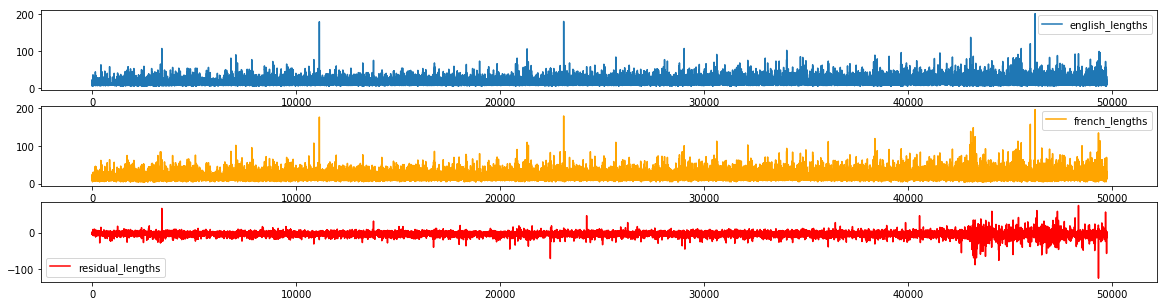

In [38]:
fig, ax = plt.subplots(3,1, figsize=(20,5))
ax[0].plot(en_len)
ax[0].legend(["english_lengths"])
ax[1].plot(fr_len, color="orange")
ax[1].legend(["french_lengths"])
ax[2].plot(np.array(en_len)- np.array(fr_len), color="r")
ax[2].legend(["residual_lengths"])

We will need to pad `x` sentences so as to form a databunch, because `x's` will go into our moedel and if they are of different length, we will not be able to leverage GPU capability fully.

```python
class SortSampler(Sampler):
    
    def __init__(self, data_source, key):
        self.data_source, self.key = data_source, key
        
    def __len__(self):
        return len(self.data_source)
    
    def __iter__(self):
        return iter(sorted(list(range(len(self.data_source))), key=self.key, reverse=True))
```

```python
class SortishSampler(Sampler):
    def __init__(self, data_source, key, bs):
        self.data_source,self.key,self.bs = data_source,key,bs

    def __len__(self) -> int: return len(self.data_source)

    def __iter__(self):
        idxs = torch.randperm(len(self.data_source))
        megabatches = [idxs[i:i+self.bs*50] for i in range(0, len(idxs), self.bs*50)]
        sorted_idx = torch.cat([tensor(sorted(s, key=self.key, reverse=True)) for s in megabatches])
        batches = [sorted_idx[i:i+self.bs] for i in range(0, len(sorted_idx), self.bs)]
        max_idx = torch.argmax(tensor([self.key(ck[0]) for ck in batches]))  # find the chunk with the largest key,
        batches[0],batches[max_idx] = batches[max_idx],batches[0]            # then make sure it goes first.
        batch_idxs = torch.randperm(len(batches)-2)
        sorted_idx = torch.cat([batches[i+1] for i in batch_idxs]) if len(batches) > 1 else LongTensor([])
        sorted_idx = torch.cat([batches[0], sorted_idx, batches[-1]])
        return iter(sorted_idx)
```

We remove the items where one of the target is more than 30 tokens long.

In [39]:
lens = np.array([(len(x), len(y)) for x, y in zip(ll.train.x, ll.train.y)])

In [40]:
np.percentile(lens[:,0], 90), np.percentile(lens[:,1], 90)

(26.0, 31.0)

In [41]:
ll

SplitData
Train: LabeledData
x: TextList (49732 items)
[[2, 7, 10, 14, 1412, 8, 3], [2, 7, 40, 62, 49, 267, 48, 8, 3], [2, 7, 10, 43, 49, 20, 465, 42, 8, 3], [2, 7, 10, 14, 9, 3659, 1070, 50, 4756, 13, 6423, 47, 11, 7, 5713, 17, 7, 2310, 13, 7, 7401, 8, 3], [2, 7, 10, 14, 9, 331, 294, 263, 27, 7, 3324, 7, 2248, 8, 3], [2, 7, 10, 16, 9, 406, 13, 906, 11, 296, 52, 1337, 5714, 1413, 18, 1129, 5714, 8, 3], [2, 7, 10, 154, 11, 538, 955, 16, 407, 39, 9, 2935, 2050, 8, 3], [2, 7, 10, 14, 9, 323, 11, 7, 46, 8, 3], [2, 7, 37, 744, 63, 9, 687, 323, 3482, 8, 3], [2, 7, 37, 744, 14, 9, 838, 7402, 8, 3]...]
Path: .
y: TextList (49732 items)
[[2, 7, 45, 18, 44, 19, 12, 2061, 8, 3], [2, 29, 65, 9212, 11, 62, 8, 3], [2, 7, 19, 11317, 11, 62, 294, 67, 8, 3], [2, 7, 39, 20, 10, 4069, 61, 4593, 14, 7812, 54, 9, 7, 0, 17, 16, 7, 964, 11, 7, 7813, 11, 0, 8, 3], [2, 7, 34, 18, 13, 238, 1300, 667, 38, 27, 2697, 9, 7, 4314, 8, 3], [2, 7, 26, 20, 10, 115, 14, 10, 2601, 35, 177, 32, 6258, 22, 520, 2517, 16, 32,

In [42]:
def cleanup_ll(ll, length=30):
    "Delets the questions where there length is greater than length"
    for i, (x, y) in enumerate(zip(ll.train.x, ll.train.y)):
        if len(x) > length or len(y) > length:
            del ll.train.x[i]
            del ll.train.y[i]
            
    for i, (x, y) in enumerate(zip(ll.valid.x, ll.valid.y)):
        if len(x) > length or len(y) > length:
            del ll.valid.x[i]
            del ll.valid.y[i]
    
    return ll 

In [43]:
ll = cleanup_ll(ll, length=30)

In [44]:
ll

SplitData
Train: LabeledData
x: TextList (45119 items)
[[2, 7, 10, 14, 1412, 8, 3], [2, 7, 40, 62, 49, 267, 48, 8, 3], [2, 7, 10, 43, 49, 20, 465, 42, 8, 3], [2, 7, 10, 14, 9, 3659, 1070, 50, 4756, 13, 6423, 47, 11, 7, 5713, 17, 7, 2310, 13, 7, 7401, 8, 3], [2, 7, 10, 14, 9, 331, 294, 263, 27, 7, 3324, 7, 2248, 8, 3], [2, 7, 10, 16, 9, 406, 13, 906, 11, 296, 52, 1337, 5714, 1413, 18, 1129, 5714, 8, 3], [2, 7, 10, 154, 11, 538, 955, 16, 407, 39, 9, 2935, 2050, 8, 3], [2, 7, 10, 14, 9, 323, 11, 7, 46, 8, 3], [2, 7, 37, 744, 63, 9, 687, 323, 3482, 8, 3], [2, 7, 37, 744, 14, 9, 838, 7402, 8, 3]...]
Path: .
y: TextList (45119 items)
[[2, 7, 45, 18, 44, 19, 12, 2061, 8, 3], [2, 29, 65, 9212, 11, 62, 8, 3], [2, 7, 19, 11317, 11, 62, 294, 67, 8, 3], [2, 7, 39, 20, 10, 4069, 61, 4593, 14, 7812, 54, 9, 7, 0, 17, 16, 7, 964, 11, 7, 7813, 11, 0, 8, 3], [2, 7, 34, 18, 13, 238, 1300, 667, 38, 27, 2697, 9, 7, 4314, 8, 3], [2, 7, 26, 20, 10, 115, 14, 10, 2601, 35, 177, 32, 6258, 22, 520, 2517, 16, 32,

`FYI`: `LabelledData` Object is a `Dataset`.

```python
DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    sampler=None,
    batch_sampler=None,
    num_workers=0,
    collate_fn=<function default_collate at 0x1a1e6009d8>,
    pin_memory=True,
    drop_last=False,
    timeout=0,
    worker_init_fn=None,
)
```

In [45]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    #print(samples[0])
    #samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = torch.LongTensor(s[0]),torch.LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = torch.LongTensor(s[0]),torch.LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [46]:
def get_se2seq_dls(ll, train_bs, val_bs, pad_idx=1, pad_first=False, backwards=False, c_fn=seq2seq_collate):
    datasets=[ll.train, ll.valid]
    collate_fn = partial(c_fn, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
    train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0]), bs=bs//2)
    train_dl = DataLoader(datasets[0], batch_size=train_bs, sampler=train_sampler, 
                          collate_fn=seq2seq_collate,drop_last=True)
    
    dataloaders = [train_dl]
    for ds in datasets[1:]:
        lengths = [len(t) for t in ds.x.items]
        sampler = SortSampler(ds.x, key=lengths.__getitem__)
        dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, collate_fn=collate_fn))
        
    return dataloaders

In [47]:
bs = 64

In [48]:
train_dl, valid_dl = get_se2seq_dls(ll, bs, bs*2)

In [49]:
x, y = next(iter(train_dl))

In [50]:
x.shape, y.shape

(torch.Size([64, 120]), torch.Size([64, 158]))

In [51]:
x

tensor([[   2,    7,   40,  ...,  523,    8,    3],
        [   1,    1,    1,  ...,  629,    8,    3],
        [   1,    1,    1,  ...,  544,    8,    3],
        ...,
        [   1,    1,    1,  ...,  319,    8,    3],
        [   1,    1,    1,  ...,  782,    8,    3],
        [   1,    1,    1,  ..., 1474,    8,    3]])

In [52]:
def seq2seq_databunch(ll, bs=64):
    return DataBunch(*get_se2seq_dls(ll, bs, bs*2))

In [53]:
data = seq2seq_databunch(ll)

In [54]:
data.train_dl.dataset

LabeledData
x: TextList (45119 items)
[[2, 7, 10, 14, 1412, 8, 3], [2, 7, 40, 62, 49, 267, 48, 8, 3], [2, 7, 10, 43, 49, 20, 465, 42, 8, 3], [2, 7, 10, 14, 9, 3659, 1070, 50, 4756, 13, 6423, 47, 11, 7, 5713, 17, 7, 2310, 13, 7, 7401, 8, 3], [2, 7, 10, 14, 9, 331, 294, 263, 27, 7, 3324, 7, 2248, 8, 3], [2, 7, 10, 16, 9, 406, 13, 906, 11, 296, 52, 1337, 5714, 1413, 18, 1129, 5714, 8, 3], [2, 7, 10, 154, 11, 538, 955, 16, 407, 39, 9, 2935, 2050, 8, 3], [2, 7, 10, 14, 9, 323, 11, 7, 46, 8, 3], [2, 7, 37, 744, 63, 9, 687, 323, 3482, 8, 3], [2, 7, 37, 744, 14, 9, 838, 7402, 8, 3]...]
Path: .
y: TextList (45119 items)
[[2, 7, 45, 18, 44, 19, 12, 2061, 8, 3], [2, 29, 65, 9212, 11, 62, 8, 3], [2, 7, 19, 11317, 11, 62, 294, 67, 8, 3], [2, 7, 39, 20, 10, 4069, 61, 4593, 14, 7812, 54, 9, 7, 0, 17, 16, 7, 964, 11, 7, 7813, 11, 0, 8, 3], [2, 7, 34, 18, 13, 238, 1300, 667, 38, 27, 2697, 9, 7, 4314, 8, 3], [2, 7, 26, 20, 10, 115, 14, 10, 2601, 35, 177, 32, 6258, 22, 520, 2517, 16, 32, 6258, 22, 2313, 

In [55]:
data.valid_dl.dataset

LabeledData
x: TextList (2325 items)
[[2, 7, 24, 16, 49, 8, 3], [2, 7, 37, 744, 14, 9, 73, 7402, 8, 3], [2, 7, 37, 1482, 14, 9, 838, 7402, 8, 3], [2, 7, 10, 14, 7, 46, 59, 323, 3482, 8, 3], [2, 7, 10, 14, 18, 7, 1590, 55, 7, 0, 241, 8, 3], [2, 7, 24, 14, 9, 7, 4456, 8, 3], [2, 7, 10, 14, 9, 7, 441, 19, 7, 5715, 7, 184, 7, 202, 50, 4760, 47, 8, 3], [2, 7, 40, 33, 38, 124, 56, 44, 191, 13, 101, 19, 249, 8, 3], [2, 7, 10, 16, 7, 0, 2322, 8, 3], [2, 7, 10, 14, 9, 7, 1738, 7, 7408, 7, 3870, 8, 3]...]
Path: .
y: TextList (2325 items)
[[2, 7, 65, 708, 11, 62, 8, 3], [2, 7, 39, 18, 12, 736, 12, 52, 0, 8, 3], [2, 7, 39, 18, 13, 1143, 13, 360, 0, 8, 3], [2, 7, 39, 18, 12, 3684, 9, 12, 297, 328, 8, 3], [2, 7, 377, 998, 43, 7, 0, 95, 7, 0, 0, 8, 3], [2, 7, 40, 18, 44, 40, 32, 4595, 8, 3], [2, 7, 45, 18, 44, 19, 13, 7, 263, 15, 185, 755, 9, 27, 4073, 61, 6262, 54, 8, 3], [2, 7, 65, 107, 199, 15, 100, 42, 159, 9, 12, 11588, 7, 684, 30, 10, 566, 333, 25, 7, 59, 8, 3], [2, 7, 40, 18, 44, 19, 10, 5347,

In [56]:
x,y = next(iter(data.train_dl))

In [57]:
x.shape, y.shape

(torch.Size([64, 120]), torch.Size([64, 158]))

In [58]:
x,y = next(iter(data.valid_dl))

In [59]:
x.shape, y.shape

(torch.Size([128, 56]), torch.Size([128, 68]))

### Modelling

#### **Pretrained Embeddings**

In [62]:
# !git clone https://github.com/facebookresearch/fastText.git
# !cd fastText
# !pip install .

In [63]:
import fastText as ft

From Documentation [here](https://github.com/facebookresearch/fastText/blob/master/docs/crawl-vectors.md)
>We distribute pre-trained word vectors for 157 languages, trained on Common Crawl and Wikipedia using fastText. These models were trained using CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives. We also distribute three new word analogy datasets, for French, Hindi and Polish.

Download Pretrained Binary Embeddings for English and French:
- English(4.2GB): https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
- French(4.2GB): https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz

In [64]:
emb_path = Path("./../../ft_embedding/")

In [65]:
fr_vecs = ft.load_model(str((emb_path/'cc.fr.300.bin')))
en_vecs = ft.load_model(str((emb_path/'cc.en.300.bin')))

In [66]:
len(en_vecs.get_words()), en_vecs.get_words()

(2000000,
 [',',
  'the',
  '.',
  'and',
  'to',
  'of',
  'a',
  '</s>',
  'in',
  'is',
  ':',
  'I',
  'for',
  'that',
  ')',
  '"',
  '(',
  'on',
  'with',
  'it',
  'you',
  'The',
  'was',
  'as',
  'are',
  'at',
  '/',
  '’',
  'be',
  'by',
  "'s",
  'this',
  'have',
  'from',
  'or',
  '!',
  'not',
  'your',
  'an',
  "'",
  'but',
  '?',
  'can',
  '-',
  'will',
  's',
  'my',
  'has',
  'all',
  'we',
  'they',
  'he',
  'his',
  'more',
  'one',
  'about',
  'their',
  "'t",
  'so',
  'which',
  'It',
  'out',
  'up',
  '...',
  'were',
  'had',
  'who',
  'like',
  ';',
  '“',
  'our',
  'would',
  '”',
  'time',
  'been',
  'if',
  'also',
  'just',
  'when',
  'her',
  'This',
  'me',
  'there',
  'do',
  'what',
  'some',
  'other',
  'In',
  'them',
  '–',
  '1',
  'get',
  'new',
  'into',
  '&',
  'We',
  'than',
  'A',
  'no',
  'only',
  'first',
  'any',
  'its',
  'people',
  '2',
  '$',
  'very',
  't',
  'over',
  'she',
  '%',
  'how',
  'make',
  'You'

similarity between `country` ans `countries`

In [67]:
from scipy import spatial

In [68]:
word_a = en_vecs.get_word_vector("country")
word_b = en_vecs.get_word_vector("countries")
1 - spatial.distance.cosine(word_a, word_b)

0.585395872592926

In [69]:
en_vecs.get_word_vector("king") - en_vecs.get_word_vector("queen")

array([-0.067891, -0.016435,  0.006704, -0.037412, ..., -0.165234,  0.065119, -0.121807, -0.055102], dtype=float32)

In [70]:
en_vecs.get_word_vector("he") - en_vecs.get_word_vector("she")

array([ 0.179449, -0.101761, -0.103363, -0.287188, ..., -0.124929,  0.726034, -0.181963, -0.044665], dtype=float32)

In [71]:
word_a = en_vecs.get_word_vector("king") - en_vecs.get_word_vector("queen")
word_b = en_vecs.get_word_vector("he") - en_vecs.get_word_vector("she")
1 - spatial.distance.cosine(word_a, word_b)

0.38982707262039185

In [72]:
def create_emb(vecs, otoi, em_sz=300, mult=1.):
    emb = nn.Embedding(len(otoi), em_sz, padding_idx=1)
    wgts = emb.weight.data
    vec_dic = {w:vecs.get_word_vector(w) for w in vecs.get_words()}
    miss = []
    count = 0
    for w,i in otoi.items():
        try: wgts[i] = tensor(vec_dic[w])
        except: 
            count +=1
            miss.append(w)
    print(f"Missed Vocab items: {count}, vocab has {(count/len(otoi))*100}% missing tokens")
    return emb, vec_dic, miss

In [73]:
print(f"Encoder has {len(data.train_dl.dataset.proc_x[-1].otoi)} vocab tokens")
print(f"Decoder has {len(data.train_dl.dataset.proc_y[-1].otoi)} vocab tokens")

Encoder has 11580 vocab tokens
Decoder has 15147 vocab tokens


In [74]:
len(data.train_dl.dataset.proc_x[-1].otoi), len(data.train_dl.dataset.proc_x[-1].vocab)

(11580, 11580)

In [75]:
len(data.train_dl.dataset.proc_y[-1].otoi), len(data.train_dl.dataset.proc_y[-1].vocab)

(15147, 15147)

In [76]:
emb_enc, enc_vec_dic, enc_miss_tokens = create_emb(en_vecs, data.train_dl.dataset.proc_x[-1].otoi)
emb_dec, dec_vec_dic, dec_miss_tokens = create_emb(fr_vecs, data.train_dl.dataset.proc_y[-1].otoi)

Missed Vocab items: 624, vocab has 5.3886010362694305% missing tokens
Missed Vocab items: 851, vocab has 5.618274245725226% missing tokens


In [77]:
model_path = Path("./")

In [78]:
os.makedirs(model_path/"models", exist_ok=True)

In [79]:
torch.save(emb_enc, model_path/'models'/'en_emb.pth')
torch.save(emb_dec, model_path/'models'/'fr_emb.pth')

Let's free some RAM

In [80]:
del fr_vecs
del en_vecs

save away

ll,vocab and embeddings

#### QRNN seq2seq

Encoder - Decoder Architecture

In [81]:
from fastai.text.models.qrnn import QRNN, QRNNLayer

The encoder is a (quasi) recurrent neural net and we feed it our input sentence, producing an output (that we discard for now) and a hidden state. That hidden state is then given to the decoder (an other RNN) which uses it in conjunction with the outputs it predicts to get produce the translation. We loop until the decoder produces a padding token (or at 30 iterations to make sure it's not an infinite loop at the beginning of training).

![](./../images/seq2seq.png)

In [82]:
data.train_dl.dataset.proc_x[-1].otoi

defaultdict(int,
            {'xxunk': 0,
             'xxpad': 1,
             'xxbos': 2,
             'xxeos': 3,
             'xxrep': 4,
             'xxwrep': 5,
             'xxup': 6,
             'xxmaj': 7,
             '?': 8,
             'the': 9,
             'what': 10,
             'of': 11,
             'to': 12,
             'and': 13,
             'is': 14,
             'in': 15,
             'are': 16,
             ',': 17,
             'a': 18,
             'for': 19,
             'do': 20,
             'why': 21,
             'be': 22,
             'you': 23,
             'who': 24,
             'or': 25,
             '-': 26,
             'on': 27,
             'this': 28,
             'that': 29,
             'have': 30,
             'your': 31,
             'when': 32,
             'can': 33,
             'should': 34,
             'will': 35,
             'does': 36,
             'which': 37,
             'i': 38,
             'with': 39,
             'where':

In [134]:
class Seq2SeqQRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, n_hid, max_len, n_layers=2, p_inp:float=0.15, p_enc:float=0.25, 
                 p_dec:float=0.1, p_out:float=0.35, p_hid:float=0.05, bos_idx:int=2, pad_idx:int=1):
        super().__init__()
        self.n_layers,self.n_hid,self.max_len,self.bos_idx,self.pad_idx = n_layers,n_hid,max_len,bos_idx,pad_idx
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(p_inp)
        self.encoder = QRNN(emb_enc.weight.size(1), n_hid, n_layers=n_layers, dropout=p_enc)
        self.out_enc = nn.Linear(n_hid, emb_enc.weight.size(1), bias=False)
        self.hid_dp  = nn.Dropout(p_hid)
        self.emb_dec = emb_dec
        self.decoder = QRNN(emb_dec.weight.size(1), emb_dec.weight.size(1), n_layers=n_layers, dropout=p_dec)
        self.out_drop = nn.Dropout(p_out)
        self.out = nn.Linear(emb_dec.weight.size(1), emb_dec.weight.size(0))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
#         print(f"input shape: {inp.shape}")
        bs,sl = inp.size()
#         print(f"bs:{bs} sl:{sl}")
        self.encoder.reset()
        self.decoder.reset()
        hid = self.initHidden(bs)
#         print(f"state shape (hid): {hid.shape}")
        emb = self.emb_enc_drop(self.emb_enc(inp))
#         print(f"emb shape: {emb.shape}")
        enc_out, hid = self.encoder(emb, hid)
#         print(f"enc_out shape: {enc_out.shape}, hid shape: {hid.shape}")
        hid = self.out_enc(self.hid_dp(hid)) # ======
#         print(f"Linear layer mapping applied to hid")
#         print(f"hid: {hid.shape}")

        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
#         print(f"dec_inp: {dec_inp.shape}")
#         print(dec_inp)
        outs = []
        for i in range(self.max_len):
            emb = self.emb_dec(dec_inp).unsqueeze(1)
#             print(f"Decoder Embedding of inp: {emb.shape}")
            out, hid = self.decoder(emb, hid) # hid is the state we transfer from encoder ========
#             print(f"out: {out.shape}")#, hid: {hid.shape}")
            out = self.out(self.out_drop(out[:,0]))
            outs.append(out)
            dec_inp = out.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
                
        result = torch.stack(outs, dim=1)
#         print(f"result shape: {result.shape}")
        return result
    
    def initHidden(self, bs): return next(self.parameters()).new_zeros(self.n_layers, bs, self.n_hid)

In [128]:
x,y = next(iter(data.train_dl))

In [129]:
x.shape, y.shape

(torch.Size([64, 120]), torch.Size([64, 158]))

In [130]:
model = Seq2SeqQRNN(emb_enc, emb_dec, 256, 30, n_layers=2)

In [131]:
outs = model(x)

input shape: torch.Size([64, 120])
bs:64 sl:120
state shape (hid): torch.Size([2, 64, 256])
emb shape: torch.Size([64, 120, 300])
enc_out shape: torch.Size([64, 120, 256]), hid shape: torch.Size([2, 64, 256])
Linear layer mapping applied to hid
hid: torch.Size([2, 64, 300])
dec_inp: torch.Size([64])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
Decoder Embedding of inp: torch.Size([64, 1, 300])
out: torch.Size([64, 1, 300])
Decoder Embedding of inp: torch.Size([64, 1, 300])
out: torch.Size([64, 1, 300])
Decoder Embedding of inp: torch.Size([64, 1, 300])
out: torch.Size([64, 1, 300])
Decoder Embedding of inp: torch.Size([64, 1, 300])
out: torch.Size([64, 1, 300])
Decoder Embedding of inp: torch.Size([64, 1, 300])
out: torch.Size([64, 1, 300])
Decoder Embedding of inp: torch.Size([64, 1, 300])
out: torch.Size([64, 1, 30

In [91]:
outs.shape

torch.Size([64, 30, 15147])

In [158]:
class Seq2SeqQRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, n_hid, max_len, n_layers=2, p_inp:float=0.15, p_enc:float=0.25, 
                 p_dec:float=0.1, p_out:float=0.35, p_hid:float=0.05, bos_idx:int=2, pad_idx:int=1):
        super().__init__()
        self.n_layers,self.n_hid,self.max_len,self.bos_idx,self.pad_idx = n_layers,n_hid,max_len,bos_idx,pad_idx
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(p_inp)
        self.encoder = QRNN(emb_enc.weight.size(1), n_hid, n_layers=n_layers, dropout=p_enc)
        self.out_enc = nn.Linear(n_hid, emb_enc.weight.size(1), bias=False)
        self.hid_dp  = nn.Dropout(p_hid)
        self.emb_dec = emb_dec
        self.decoder = QRNN(emb_dec.weight.size(1), emb_dec.weight.size(1), n_layers=n_layers, dropout=p_dec)
        self.out_drop = nn.Dropout(p_out)
        self.out = nn.Linear(emb_dec.weight.size(1), emb_dec.weight.size(0))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        bs,sl = inp.size()
        self.encoder.reset()
        self.decoder.reset()
        hid = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.encoder(emb, hid)
        hid = self.out_enc(self.hid_dp(hid))

        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        outs = []
        for i in range(self.max_len):
            emb = self.emb_dec(dec_inp).unsqueeze(1)
            out, hid = self.decoder(emb, hid)
            out = self.out(self.out_drop(out[:,0]))
            outs.append(out)
            dec_inp = out.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(outs, dim=1)
    
    def initHidden(self, bs): return next(self.parameters()).new_zeros(self.n_layers, bs, self.n_hid)

In [159]:
Seq2SeqQRNN

__main__.Seq2SeqQRNN

###### seq2seq loss

```python
def cross_entropy_flat(input, target):
    bs,sl = target.size()
    return F.cross_entropy(input.view(bs * sl, -1), target.view(bs * sl))
```

In [ ]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return cross_entropy_flat(out, targ)

In [191]:
def seq2seq_loss(inputs, targets):
    #pdb.set_trace()
    src_bs, src_seq_len, nc = inputs.shape
    trg_bs, trg_seq_len = targets.shape
    
    if trg_seq_len > src_seq_len: inputs = F.pad(inputs, (0,0,0,trg_seq_len - src_seq_len, 0,0))

    inputs = inputs[:, :trg_seq_len]
    return F.cross_entropy(inputs.contiguous().view(-1, nc), targets.contiguous().view(-1))

In [ ]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

##### **Finding the learning rate**

In [ ]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [ ]:
cbs = [partial(AvgStatsCallback,seq2seq_acc),
       partial(CudaCallback, get_device()), 
       Recorder,
       LR_Find,
       ProgressCallback]

In [ ]:
model = Seq2SeqQRNN(emb_enc, emb_dec, 256, 30, n_layers=2)
learn = Learner(model, data, loss_func=seq2seq_loss, cb_funcs=cbs, opt_func=adam_opt())

In [ ]:
path

In [ ]:
torch.save(learn.model.state_dict(), path/"init_model.pth")

In [ ]:
learn.fit(1)

In [ ]:
learn.recorder.plot(skip_last=15)

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.model.load_state_dict(torch.load(path/"init_model.pth", map_location=get_device()))

#### Training a model

In [211]:
cbs = [partial(AvgStatsCallback,seq2seq_acc),
       partial(CudaCallback, get_device()), 
       Recorder,
       partial(SaveModelCallback, every="epoch", savename="check_model"),
       partial(GradientClipping, clip=0.1),
       ProgressCallback]

In [212]:
emb_enc = torch.load(model_path/'models'/'en_emb.pth')
emb_dec = torch.load(model_path/'models'/'fr_emb.pth')

In [213]:
model = Seq2SeqQRNN(emb_enc, emb_dec, 256, 50, n_layers=2,  
                    p_enc=0.0, p_dec=0.0, p_out=0.0, p_hid=0.0)
learn = Learner(model, data, loss_func=seq2seq_loss, cb_funcs=cbs, opt_func=adam_opt())
# load the model for which the lr_find was run
learn.model.load_state_dict(torch.load(path/"init_model.pth", map_location=get_device()))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [214]:
#export
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [216]:
lr = 1e-5 # 1e-2 #
sched_lr  = combine_scheds([0.3,0.7], cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.8, 0.7, 0.8))
cbsched = [ParamScheduler('lr', sched_lr), ParamScheduler('mom', sched_mom)]

In [217]:
learn.fit(1, cbs=cbsched)

epoch,train_loss,train_seq2seq_acc,valid_loss,valid_seq2seq_acc,time


KeyboardInterrupt: 

Model is not learning anything at the moment. `Investigate`

#### Get predictions

In [110]:
x,y = next(iter(learn.data.train_dl))

In [111]:
x.shape, y.shape

(torch.Size([64, 120]), torch.Size([64, 158]))

In [112]:
learn.model.eval()

Seq2SeqQRNN(
  (emb_enc): Embedding(11580, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15)
  (encoder): QRNN(
    (layers): ModuleList(
      (0): QRNNLayer(
        (linear): Linear(in_features=600, out_features=768, bias=True)
      )
      (1): QRNNLayer(
        (linear): Linear(in_features=256, out_features=768, bias=True)
      )
    )
  )
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (hid_dp): Dropout(p=0.05)
  (emb_dec): Embedding(15147, 300, padding_idx=1)
  (decoder): QRNN(
    (layers): ModuleList(
      (0): QRNNLayer(
        (linear): Linear(in_features=600, out_features=900, bias=True)
      )
      (1): QRNNLayer(
        (linear): Linear(in_features=300, out_features=900, bias=True)
      )
    )
  )
  (out_drop): Dropout(p=0.35)
  (out): Linear(in_features=300, out_features=15147, bias=True)
)

In [113]:
out = learn.model(x)

In [114]:
out.shape

torch.Size([64, 1, 15147])

In [ ]:
learn.model.train()

In [122]:
def get_predictions(learn):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    
    with torch.no_grad():
        for xb,yb in progress_bar(learn.data.valid_dl):
            print(f"inps: {xb.shape}")
            out = learn.model(xb)
            print(f"outs: {out.shape}")
            for x in xb:
                inputs.append(learn.data.train_dl.dataset.obj([x],0, learn.data.train_dl.dataset.proc_x))
#                 targets.append(learn.data.train_dl.dataset.obj([y],0, learn.data.train_dl.dataset.proc_y))
#                 outputs.append(learn.data.train_dl.dataset.obj([z.argmax(1)],0, learn.data.train_dl.dataset.proc_y))
                
            for y in yb:
#                 inputs.append(learn.data.train_dl.dataset.obj([x],0, learn.data.train_dl.dataset.proc_x))
                targets.append(learn.data.train_dl.dataset.obj([y],0, learn.data.train_dl.dataset.proc_y))
#                 outputs.append(learn.data.train_dl.dataset.obj([z.argmax(1)],0, learn.data.train_dl.dataset.proc_y))
                
            for z in out:
#                 inputs.append(learn.data.train_dl.dataset.obj([x],0, learn.data.train_dl.dataset.proc_x))
#                 targets.append(learn.data.train_dl.dataset.obj([y],0, learn.data.train_dl.dataset.proc_y))
                outputs.append(learn.data.train_dl.dataset.obj([z.argmax(1)],0, learn.data.train_dl.dataset.proc_y))

    return inputs, targets, outputs

In [123]:
inputs, targets, outputs = get_predictions(learn)

inps: torch.Size([128, 56])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 24])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 22])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 20])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 19])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 18])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 17])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 16])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 15])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 15])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 14])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 13])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 12])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 12])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 11])
outs: torch.Size([128, 1, 15147])
inps: torch.Size([128, 10])
outs: torch.Size([128, 1, 15147])
inps: to

model is only predicting xpad at which point, it stops producing next tokens. Something is wrong, Not sure what

In [286]:
inputs[:2], targets[:2], outputs[:2]

(['xxbos xxmaj what is the opinion of the federal , provincial and municipal governments as to the effect of current and proposed trade and investment agreements such as nafta , ftaa and the xxunk on their ability to fulfill obligations under the xxmaj covenant and what processes have been put in place to review these questions ? xxeos',
  'xxbos xxmaj what does the xxmaj office of the xxmaj superintendent of xxmaj bankruptcy mean by the term " xxmaj trustee " in xxmaj part 1 of the xxmaj annual xxmaj banking xxmaj report ( abr ) xxmaj form ( xxmaj schedule 3 of directive xxunk ) , and which trustee license numbers should be included ? xxeos'],
 ["xxbos xxmaj quel est l' avis du xxmaj gouvernement fédéral et des gouvernements provinciaux et municipaux quant à l' effet des accords sur le commerce et les investissements actuels ou envisagés tels que l' xxmaj accord de libre-échange nord-américain , la zone de libre-échange des xxmaj amériques et l' xxmaj accord multilatéral sur l' invest

In [124]:
len(inputs), len(targets), len(outputs)

(2325, 2325, 2325)

In [125]:
seek = 3
inputs[seek], targets[seek], outputs[seek]

('xxbos xxmaj where additional mitigating controls have been put in place , is management satisfied that these controls are effective and that the risks involved have been reduced to an acceptable level ( considering impact and likelihood of the risk ) ? xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad',
 "xxbos xxmaj lorsque des fonctions sensibles ont été retirées et transférées à un autre membre du personnel , l' encadrement a -t -il pu établir que les risques associés avaient bien été efficacement atténués ? xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",
 'xxpad')

In [126]:
seek = 100
inputs[seek], targets[seek], outputs[seek]

('xxbos xxmaj what was the level of collaboration on climate change between the two levels of government prior to the inception of oe ? xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad',
 'xxbos xxmaj quel a été le niveau de collaboration en matière de changements climatiques entre les deux ordres de gouvernement avant la mise en œuvre de l’ enp ? xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad',
 'xxpad')

### Debugging the model 

In [ ]:
nn.Embedding(19110,300)

In [218]:
learn.model.emb_enc

Embedding(11268, 300, padding_idx=1)

In [ ]:
en_vocab.index("country")

In [ ]:
learn.model.eval()

In [ ]:
learn.model.emb_enc(tensor(10)).data.numpy()

In [ ]:
def get_emb_vec(word, emb, vocab):
    return emb(tensor(vocab.index("what"))).data.numpy()

In [ ]:
countries_vec = get_emb_vec("countries", emb_enc, vocab=en_vocab)

In [ ]:
country_vec = get_emb_vec("country", emb_enc, vocab=en_vocab)

In [ ]:
result = 1 - spatial.distance.cosine(countries_vec, country_vec)
result

In [ ]:
def get_word_similarity(word_A, word_B, vocab=en_vocab):
    A_vec = get_emb_vec(word_A, vocab=vocab)
    B_vec = get_emb_vec(word_A, vocab=vocab)
    result = 1 - spatial.distance.cosine(countries_vec, country_vec)
    return result

In [ ]:
get_word_similarity("countries", "country", vocab=en_vocab)

In [ ]:
get_word_similarity("he", "dog", vocab=en_vocab)

In [ ]:
learn.model.emb_enc.weight.data.numpy()

In [ ]:
en_vocab.index("she")

In [290]:
learn.model.emb_enc.weight.data.numpy().mean(), learn.model.emb_enc.weight.data.numpy().std()

(0.00020116309, 0.23975705)

In [291]:
learn.model.emb_dec.weight.data.numpy().mean(), learn.model.emb_dec.weight.data.numpy().std()

(-0.0008780555, 0.24237052)

In [292]:
test_embedding = nn.Embedding(11268,300)

In [293]:
test_embedding.weight.data.numpy().mean(), test_embedding.weight.data.numpy().std()

(0.00043479208, 1.00023)

Checking if the model has learnt by calculating the loss from learned and a new untrained model

In [234]:
x,y = next(iter(data.train_dl))

In [235]:
x.shape, y.shape

(torch.Size([64, 179]), torch.Size([64, 177]))

In [236]:
model = Seq2SeqQRNN(emb_enc, emb_dec, 256, 30, n_layers=2)

In [237]:
outs = model(x)

In [238]:
outs.shape

torch.Size([64, 30, 14716])

In [239]:
seq2seq_loss(outs, y)

tensor(9.6233, grad_fn=<NllLossBackward>)

In [240]:
learn.model.eval()

Seq2SeqQRNN(
  (emb_enc): Embedding(11268, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15)
  (encoder): QRNN(
    (layers): ModuleList(
      (0): QRNNLayer(
        (linear): Linear(in_features=600, out_features=768, bias=True)
      )
      (1): QRNNLayer(
        (linear): Linear(in_features=256, out_features=768, bias=True)
      )
    )
  )
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (hid_dp): Dropout(p=0.05)
  (emb_dec): Embedding(14716, 300, padding_idx=1)
  (decoder): QRNN(
    (layers): ModuleList(
      (0): QRNNLayer(
        (linear): Linear(in_features=600, out_features=900, bias=True)
      )
      (1): QRNNLayer(
        (linear): Linear(in_features=300, out_features=900, bias=True)
      )
    )
  )
  (out_drop): Dropout(p=0.35)
  (out): Linear(in_features=300, out_features=14716, bias=True)
)

In [241]:
outs = learn.model(x)

In [242]:
seq2seq_loss(outs, y)

tensor(9.5423, grad_fn=<NllLossBackward>)

the loss is pretty much the same, indicating nothing has been learnt.

In [247]:
emb_enc(tensor(data.train_dl.dataset.proc_x[-1].vocab.index("sex")))

tensor([ 0.2401,  0.2031,  0.1832,  0.2171, -0.0473, -0.3082, -0.0011, -0.0289,
        -0.2395, -0.1497,  0.0066, -0.0778,  0.1862,  0.1748,  0.0791,  0.0541,
        -0.3321,  0.0370, -0.1699,  0.0915, -0.0260,  0.0261,  0.1555,  0.1727,
         0.0147,  0.0768, -0.1331, -0.0587,  0.0098,  0.3628, -0.2885, -0.1653,
         0.1333, -0.0808,  0.1416,  0.2881,  0.1038,  0.0473,  0.0769,  0.0045,
         0.1630, -0.0993, -0.1769,  0.0231, -0.2812, -0.0150,  0.1250,  0.1198,
        -0.0401,  0.1851,  0.0828,  0.0337, -0.0906,  0.2683, -0.0905, -0.0633,
         0.1162, -0.0876, -0.2628, -0.1547, -0.0460,  0.1208, -0.0299, -0.0335,
        -0.0720, -0.0599,  0.0821,  0.1856, -0.3330,  0.1103, -0.0348, -0.0992,
        -0.0480, -0.0410, -0.1535, -0.2319,  0.0789, -0.0466, -0.0983,  0.0319,
        -0.1254,  0.0245,  0.1328, -0.0243,  0.1437, -0.0455,  0.1431,  0.0478,
         0.0541,  0.0650, -0.0975,  0.1100,  0.0606, -0.2040,  0.1636,  0.0746,
         0.0059,  0.2718, -0.0400, -0.13

In [248]:
learn.model.emb_enc(tensor(data.train_dl.dataset.proc_x[-1].vocab.index("sex")))

tensor([ 0.2401,  0.2031,  0.1832,  0.2171, -0.0473, -0.3082, -0.0011, -0.0289,
        -0.2395, -0.1497,  0.0066, -0.0778,  0.1862,  0.1748,  0.0791,  0.0541,
        -0.3321,  0.0370, -0.1699,  0.0915, -0.0260,  0.0261,  0.1555,  0.1727,
         0.0147,  0.0768, -0.1331, -0.0587,  0.0098,  0.3628, -0.2885, -0.1653,
         0.1333, -0.0808,  0.1416,  0.2881,  0.1038,  0.0473,  0.0769,  0.0045,
         0.1630, -0.0993, -0.1769,  0.0231, -0.2812, -0.0150,  0.1250,  0.1198,
        -0.0401,  0.1851,  0.0828,  0.0337, -0.0906,  0.2683, -0.0905, -0.0633,
         0.1162, -0.0876, -0.2628, -0.1547, -0.0460,  0.1208, -0.0299, -0.0335,
        -0.0720, -0.0599,  0.0821,  0.1856, -0.3330,  0.1103, -0.0348, -0.0992,
        -0.0480, -0.0410, -0.1535, -0.2319,  0.0789, -0.0466, -0.0983,  0.0319,
        -0.1254,  0.0245,  0.1328, -0.0243,  0.1437, -0.0455,  0.1431,  0.0478,
         0.0541,  0.0650, -0.0975,  0.1100,  0.0606, -0.2040,  0.1636,  0.0746,
         0.0059,  0.2718, -0.0400, -0.13

In [246]:
data.train_dl.dataset.proc_x[-1].vocab.index("sex")

1556